In [1]:
from bids import BIDSLayout
import numpy as np
import pandas as pd
import os

from matplotlib import pyplot as plt
from matplotlib import gridspec 
from matplotlib.lines import Line2D
import seaborn as sns
import dabest

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.genmod.families.links import Log
from scipy.stats import binomtest, beta, binom

import pymc as pm
import arviz as az
import bayesprev

np.random.seed(0)

In [2]:
layout = BIDSLayout('bids_dataset')
if not os.path.exists('figures'):
    os.mkdir('figures')

In [3]:
dfs = []
subs = layout.get_subjects()
subs.sort(key = int)
for sub in subs:
    fpaths = layout.get(
        return_type = 'filename', 
        task = 'rivalry', 
        suffix = 'events', 
        subject = sub
    )
    df = pd.concat([pd.read_csv(f, sep = '\t') for f in fpaths])
    df['subject'] = sub
    dfs.append(df)
df = pd.concat(dfs)
df = df.dropna()

In [4]:
# get subject-level means for left eye, right eye, and both eyes
df_by_sub = df.groupby(by = ['subject', 'dominant'], as_index = False).mean(numeric_only = True)
df_by_sub['key'] = 'all'
df_by_eye = df.groupby(by = ['subject', 'key', 'dominant'], as_index = False).mean(numeric_only = True)
df_mean = pd.concat([df_by_sub, df_by_eye])
df_mean['side'] = df_mean.key
df_mean.dominant = df_mean.dominant.replace({'synchronous': 'systole', 'asynchronous': 'diastole'})
df_mean['dominance dur (s)'] = df_mean.duration
df_mean['dominance duration (s)'] = df_mean.duration # alias 

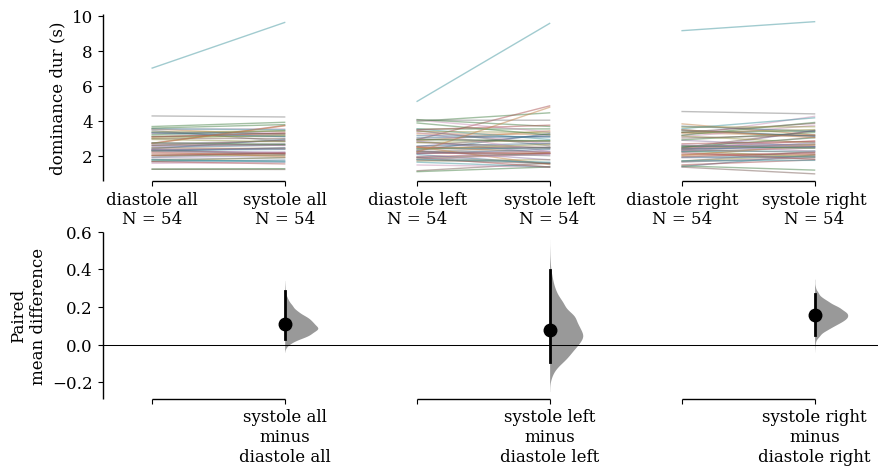

In [5]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams.update({'font.size': 12})

data = dabest.load(
    data = df_mean,
    x = ['dominant', 'subject'], y = 'dominance dur (s)', 
    id_col = 'subject',
    paired = 'baseline',
    experiment = 'side',
    delta2 = True,
    random_seed = 0
)
fig, ax = plt.subplots(figsize = (10, 5), constrained_layout = True)
data.mean_diff.plot(ax = ax, show_delta2 = False)
ax.get_legend().set_visible(False)
fpath = os.path.join('figures', 'paired-diffs.jpeg')
plt.savefig(fpath, dpi = 500, bbox_inches = 'tight')
plt.show()

In [6]:
data.mean_diff.results[[
    'control', 'test', 
    'difference', 'ci', 
    'bca_low', 'bca_high', 
    'pvalue_permutation'
]]

,control,test,difference,ci,bca_low,bca_high,pvalue_permutation
0,diastole all,systole all,0.10845,95,0.029797,0.285603,0.0518
1,diastole left,systole left,0.07819,95,-0.093219,0.394944,0.5564
2,diastole right,systole right,0.15598,95,0.049708,0.268130,0.0058


In [7]:
data.cohens_d.results[[
    'control', 'test', 
    'difference', 'ci', 
    'bca_low', 'bca_high', 
    'pvalue_permutation'
]]

,control,test,difference,ci,bca_low,bca_high,pvalue_permutation
0,diastole all,systole all,0.102199,95,0.014440,0.181054,0.0518
1,diastole left,systole left,0.072379,95,-0.124211,0.276851,0.5564
2,diastole right,systole right,0.131677,95,0.008432,0.270995,0.0058


In [8]:
mod = smf.gee(
    "duration ~ dominant", 
    groups = "subject", # random effect of subject
    cov_struct = sm.cov_struct.Exchangeable(), 
    family = sm.families.Gamma(link = Log()),
    data = df
)
res = mod.fit(cov_type = 'bias_reduced') 
print(res.summary())

                               GEE Regression Results                              
Dep. Variable:                    duration   No. Observations:                26367
Model:                                 GEE   No. clusters:                       54
Method:                        Generalized   Min. cluster size:                 136
                      Estimating Equations   Max. cluster size:                 974
Family:                              Gamma   Mean cluster size:               488.3
Dependence structure:         Exchangeable   Num. iterations:                     7
Date:                     Fri, 01 Dec 2023   Scale:                           0.577
Covariance type:              bias_reduced   Time:                         15:01:17
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.9764      0.050     19.352    

In [9]:
to_perc = lambda beta: 100 * (np.exp(beta) - 1) # map coefficient to percent increase
perc_inc = to_perc(res.params[1])
ci = res.conf_int(alpha = .05).iloc[1, :].to_numpy()
lower, upper = to_perc(ci)
print('Percent increase in dominance duration: %.02f%% [%.02f, %.02f]'%(perc_inc, lower, upper))

Percent increase in dominance duration: 2.64% [0.24, 5.09]


In [10]:
sub_dfs = []
for f in layout.get(task = 'discrimination', suffix = 'events'):
    sub_df = pd.read_csv(f.path, sep = '\t')
    sub_df['subject'] = f.entities['subject']
    sub_dfs.append(sub_df)
disc_df = pd.concat(sub_dfs)

In [11]:
n = sub_dfs[0].shape[0] # number of trials
acc = disc_df.groupby('subject', as_index = False).sum(numeric_only = True)
acc['pval'] = acc.correct.apply(lambda x: binomtest(x, n, alternative = 'greater').pvalue)
n_trials = sub_dfs[0].shape[0]
acc['accuracy'] = acc.correct / n_trials
acc.head()

,subject,onset,duration,correct,pval,accuracy
0,01,91891.475800,1201.566510,59,0.607836,0.491667
1,02,87025.014624,1201.498062,58,0.675870,0.483333
2,03,90701.978936,1201.936128,56,0.794288,0.466667
3,04,89673.242769,1201.954043,56,0.794288,0.466667
4,05,99856.391070,1201.458450,79,0.000333,0.658333


In [12]:
prop = (acc.pval <= .05).sum() / acc.shape[0]
print('%.02f%% of subjects were above-chance heartbeat perceivers.'%(100*prop))

9.26% of subjects were above-chance heartbeat perceivers.


In [13]:
with pm.Model() as interoception_model:

    prop_above_chance = pm.Uniform('prevalence', 0., 1.)

    # chance distribution
    chance_logp = pm.logp(pm.Binomial.dist(n = n_trials, p = 0.5), acc.correct.to_numpy())

    # above-chance distribution
    a = pm.Exponential('a', 1.0)
    b = pm.Exponential('b', 0.5) 
    _p = pm.Beta('_p', a, b)
    p = .5 + _p/2
    _ = pm.Deterministic('accuracy', .5 + (a / (a + b))/2)
    above_chance_logp = pm.logp(pm.Binomial.dist(n = n_trials, p = p), acc.correct.to_numpy())
    
    # whether each subject is an above-chance performer  
    is_above_chance = pm.Bernoulli(
        "is_above_chance",
        p = prop_above_chance,
        shape = acc.shape[0],
        initval = (np.random.rand(acc.shape[0]) < 0.4) * 1, # init sampler with class asymmetry
    )  

    # evaluate log-probs w/ non-sampled Potential 
    potential = pm.Potential(
        "obs",
        pm.math.sum((1 - is_above_chance) * chance_logp) + pm.math.sum(is_above_chance * above_chance_logp),
    )    

In [14]:
with interoception_model:
    trace = pm.sample(
        tune = 5000,
        draws = 2500,
        chains = 4,
        cores = 4,
        init = "jitter+adapt_diag",
        nuts = {"target_accept": 0.99},
        return_inferencedata = True,
        random_seed = 1
    )


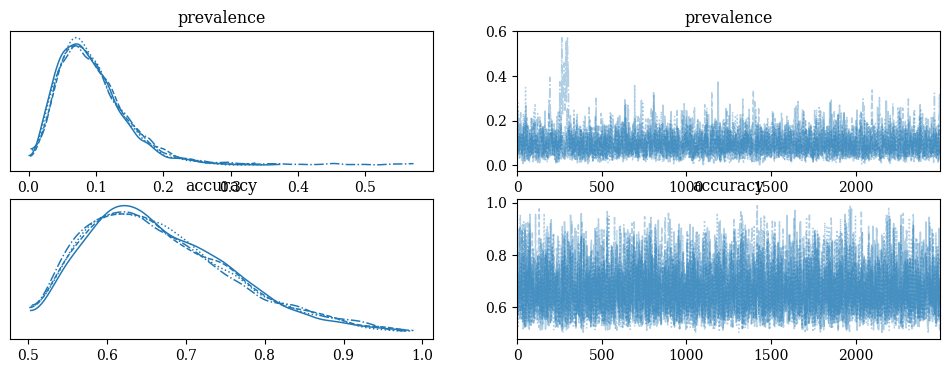

In [15]:
rvs = ['prevalence', 'accuracy']
_ = az.plot_trace(trace, var_names = rvs)

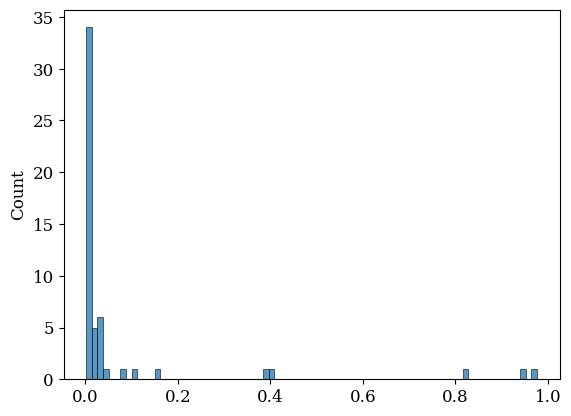

In [16]:
# get posterior probability each subject is an above-chance perceiver 
trc = trace.stack(sample = ['chain', 'draw'])
samples = trc.posterior.is_above_chance.values
prob_above_chance = samples.mean(1)
acc['prob_above_chance'] = prob_above_chance
sns.histplot(prob_above_chance)
plt.show()

In [17]:
bayesian_cutoff = acc.accuracy[prob_above_chance <= .05].max()
bayesian_cutoff

0.5416666666666666

In [18]:
(prob_above_chance <= .05).mean() # percent we're 95% sure are at-chance

0.8518518518518519

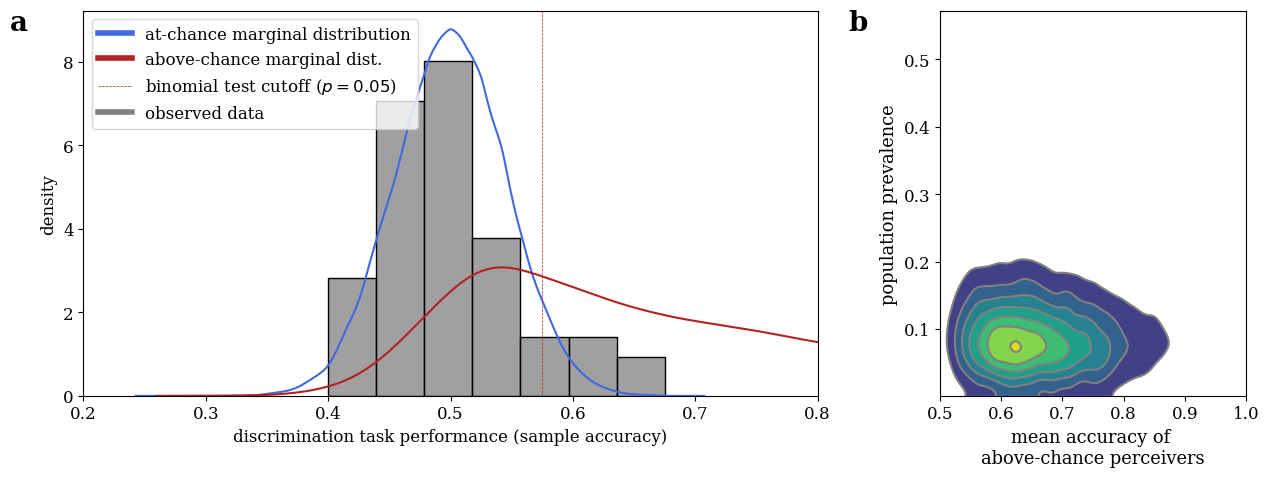

In [19]:
def add_label(ax, label, x_offset):
    xmin, xmax = ax.get_xlim()
    xscale = xmax - xmin
    ymin, ymax = ax.get_ylim()
    yscale = ymax - ymin
    ax.text(
        xmin - x_offset * xscale, ymax - .05 * yscale, 
        label, size = 20, weight = 'bold'
    )


# draw posterior predictive samples
a = trc.posterior.a.values
b = trc.posterior.b.values
p = .5 + beta.rvs(a, b, random_state = 0)/2
k = binom.rvs(n_trials, p, random_state = 1) / n_trials
k_binom = binom.rvs(n_trials, .5, size = 50000, random_state = 2) / n_trials

## and plot

fig = plt.figure(figsize = (15, 5))
gs = gridspec.GridSpec(1, 3, wspace = .4)
ax = fig.add_subplot(gs[:2])

sns.histplot(acc.accuracy, stat = 'density', color = 'gray', ax = ax)
sns.kdeplot(k_binom, color = 'royalblue', ax = ax)
sns.kdeplot(k, color = 'firebrick', ax = ax)

cutoff = binom.isf(.05, sub_dfs[0].shape[0], .5) / sub_dfs[0].shape[0]
ax.axvline(cutoff, linestyle = '--', linewidth = .5, color = 'firebrick')

custom_lines = [Line2D([0], [0], color = 'royalblue', lw = 4),
                Line2D([0], [0], color = 'firebrick', lw = 4),
                Line2D([0], [0], color = 'firebrick', linestyle = '--', lw = .5),
                Line2D([0], [0], color = 'gray', lw = 4),
               ]
ax.legend(
    custom_lines, 
    ['at-chance marginal distribution', 'above-chance marginal dist.', 
     'binomial test cutoff ($p = 0.05$)', 'observed data'
    ],
    loc = 'upper left'
)
ax.set_xlim(.2, .8)
ax.set_xlabel('discrimination task performance (sample accuracy)')
ax.set_ylabel('density')

ax0 = ax

ax = fig.add_subplot(gs[-1])
az.plot_pair(
    trace, var_names = ['accuracy', 'prevalence'], 
    kind = 'kde',
    textsize = 12, 
    ax = ax
)
ax.set_ylabel('population prevalence')
ax.set_xlabel('mean accuracy of \nabove-chance perceivers')
ax.set_xlim(.5, 1.)

ax1 = ax

add_label(ax0, 'a', .1)
add_label(ax1, 'b', .3)

fpath = os.path.join('figures', 'mixture-model.jpeg')
plt.savefig(fpath, dpi = 500, bbox_inches = 'tight')
plt.show()

In [20]:
trc.posterior.prevalence.values.mean()

0.09481063740040171

In [21]:
trc.posterior.accuracy.values.mean()

0.6683829967279045

In [22]:
az.hdi(trace, var_names = rvs)

<xarray.Dataset>
Dimensions:     (hdi: 2)
Coordinates:
  * hdi         (hdi) <U6 'lower' 'higher'
Data variables:
    prevalence  (hdi) float64 0.01181 0.1844
    accuracy    (hdi) float64 0.5212 0.8473

In [23]:
# re-run model with only subjects we're 95% sure are at-chance
at_chance_subs = df[df.subject.isin(acc.subject[prob_above_chance < .05])]
mod = smf.gee(
    "duration ~ dominant", 
    groups = "subject", # random effect of subject
    cov_struct = sm.cov_struct.Exchangeable(), 
    family = sm.families.Gamma(link = Log()),
    data = at_chance_subs
)
res = mod.fit(cov_type = 'bias_reduced') 
print(res.summary())

                               GEE Regression Results                              
Dep. Variable:                    duration   No. Observations:                22448
Model:                                 GEE   No. clusters:                       46
Method:                        Generalized   Min. cluster size:                 136
                      Estimating Equations   Max. cluster size:                 974
Family:                              Gamma   Mean cluster size:               488.0
Dependence structure:         Exchangeable   Num. iterations:                     7
Date:                     Fri, 01 Dec 2023   Scale:                           0.568
Covariance type:              bias_reduced   Time:                         15:03:43
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.9773      0.057     17.029    